In [ ]:
%pylab inline

This notebook contains code to reproduce the following from Mitra, et al.:

**Main Figures:** 
* Figure 3A: Number of mutations by category in siblings/probands
* Figure 3B: RR by category
* Figure 3C: Mutation size by category
* Figure 4A: RR by AF bin
* Figure 4B: RR by AF bin/locus selection
* Figure 4C: RR by AF bin/allele selection

**Supplementary Tables:** 
* Supplementary Table 5: excess by phase
* Supplementary Table 6: coding mutations (auto+X)
* Supplementary Table 7: deleterious mutations
* Supplementary Table 8: expansions (auto+X)

**Statistics:**
* Mean num proband autosomal mutations
* Mean num sibling autosomal mutations
* Excess in probands vs. siblings (ttest rel, RR)
* Excess in probands vs. siblings after adjust for paternal age (ttest rel)
* Excess in probands vs. siblings after adjust for paternal age + remove homopolymers(ttest rel)
* Mutation excess in male/female chrX
* RR by category

In [22]:
# Input mutation results
MUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.final_qc_mutations.tab"
NAIVEMUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_011720_denovos_naive_Jan20.final_qc_mutations.tab"

MUTFILEX = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/SSC_allphases_072820_denovos_model_X.denovos.final_qc_mutations.tab"
NAIVEMUTFILEX = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_072820_denovos_naive_X.denovos.final_qc_mutations.tab"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import statsmodels.api as sm

# Color keys
colors = ['gray','red','gold','blue','green','purple','brown','salmon','magenta','cyan','darkblue']

# Other data paths
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation-rmdup.bed"
AFREQFILE = "/storage/mgymrek/ssc-denovos/allele-freqs-revision/SSC_merged_allele_counts.tab"
HETFILE = "/storage/mgymrek/ssc-denovos/allele-freqs-revision/SSC_merged_het.tab"
AGEFILE = "/storage/ileena/denovos4/metadata/ssc_4phases_ages.csv"
SFARIFILE = "/storage/mgymrek/ssc-denovos/annotations/SFARI-Gene_genes_08-29-2019release_09-11-2019export.csv"
JACKGENES = "/storage/mgymrek/ssc-denovos/annotations/jack_102genes.txt"
CONSTRAINTFILE="/storage/mgymrek/ssc-denovos/mutea/MUTEA_Constraint_hg38_GangSTR.bed"

# Output path info
OUTDIR = "pdfs/"

In [24]:
# Load expansions
ndata = pd.read_csv(NAIVEMUTFILE, sep="\t")
ndata = ndata[(ndata["posterior"]==-1) & (ndata["mutsize"]>=5)] # moderately big expansion events

# Filter ones that occur too many times
expcounts = ndata.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata = pd.merge(ndata, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])

# Load main mutations data
alldata = pd.read_csv(MUTFILE, sep="\t")
usefams = set(alldata["family"])

# Concatenate expansions
ndata = ndata[ndata.family.isin(usefams)]
alldata = pd.concat([alldata, ndata])

# Load chrX
alldata_x = pd.read_csv(MUTFILEX, sep="\t")
alldata_x = alldata_x[alldata_x.family.isin(usefams)]
ndata_x = pd.read_csv(NAIVEMUTFILEX, sep="\t")
ndata_x = ndata_x[(ndata_x["posterior"]==-1) & (ndata_x["mutsize"]>=5)] # moderately big expansion events
expcounts = ndata_x.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata_x = pd.merge(ndata_x, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])
ndata_x = ndata_x[ndata_x.family.isin(usefams)]
alldata_x = pd.concat([alldata_x, ndata_x]).drop_duplicates()

# Manually remove problematic families. 
# 14151 proband had 130 mutations
# other families have <20 in both proband and sibling
rmfams = [14151, 12434, 12281, 13673, 13351, 13355, 13143]
alldata = alldata[~alldata.family.isin(rmfams)]
alldata_x = alldata_x[~alldata_x.family.isin(rmfams)]

# Load annotation info
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
alldata["chrom"] = alldata["chrom"].apply(GetChrom)
annot = annot[annot["chrom"].apply(lambda x: x not in ["X","chrX","Y","chrY"])]
annot["chrom"] = annot["chrom"].apply(GetChrom)
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(alldata, annot, on=["chrom","pos"])

# Get age info
ages = pd.read_csv(AGEFILE)
ages["family"] = ages["fam_id"]
ages["child"] = ages["sample_id"]
ages["phenotype"] = ages["ssc_id"].apply(lambda x: [1,2]["p1" in x])
ages = ages[~np.isnan(ages["father_age_birth"])]

alldata_x = pd.merge(alldata_x, ages[["child","sex"]], how="left")

In [3]:
# Get Allele freq info
het = pd.read_csv(HETFILE, sep="\t")
het["chrom"] = het["chrom"].apply(GetChrom)

afreq = pd.read_csv(AFREQFILE, sep="\t")
afreq.columns = ["chrom","pos","newallele","count"]
afreq["chrom"] = afreq["chrom"].apply(GetChrom)
afreq = pd.merge(afreq, het[["chrom","pos","total"]], on=["chrom","pos"])
afreq["freq"] = afreq.apply(lambda x: float(x["count"])/x["total"], 1)

fdata = pd.merge(adata, afreq, on=["chrom","pos","newallele"], how="left")
fdata.ix[np.isnan(fdata["freq"]),"freq"] = 0
fdata.ix[np.isnan(fdata["count"]),"count"] = 0
fdata = fdata.drop("total", 1)
fdata = pd.merge(fdata, het[["chrom","pos","het","total"]], on=["chrom","pos"])

finaldata = pd.merge(fdata, ages[["family","child","sex","father_age_birth_years"]], on=["family","child"], how="left")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


In [181]:
AFF_COLOR = "red"
UNAFF_COLOR = "blue"

def GetCounts(df, pt, families, sex=None):
    famcounts = {}
    counts = df[df["phenotype"]==pt]
    if sex is not None:
        counts = counts[counts["sex"]==sex]
    for i in range(counts.shape[0]):
        fam = counts["family"].values[i]
        count = counts["nummut"].values[i]
        famcounts[fam] = count
    mutcounts = [famcounts.get(family, 0) for family in families]
    return mutcounts

def TestBurden(usedata):
    # Get counts
    families = set(usedata["family"])
    child_counts = usedata.groupby(["child","phenotype","family","father_age_birth_years"], as_index=False).agg({"posterior": len})
    child_counts.columns = ["child","phenotype","family","father_age_birth_years","nummut"]
    aff_counts = GetCounts(child_counts, 2, families)
    unaff_counts = GetCounts(child_counts, 1, families)
    
    # Overall
    print("#### No adjustment ####")
    print("Unaff mean=%s"%np.mean(unaff_counts))
    print("Aff mean=%s"%np.mean(aff_counts))
    print("Mean diff=%s"%(np.mean(aff_counts)-np.mean(unaff_counts)))
    print(scipy.stats.ttest_rel(unaff_counts, aff_counts))
    
    # Adjust paternal age
    print("#### Correct for paternal age ####")
    unaff_counts = child_counts[child_counts["phenotype"]==1]
    X = sm.add_constant(np.array(unaff_counts[["father_age_birth_years"]]))
    Y = np.array(unaff_counts["nummut"])
    model = sm.OLS(Y, X).fit()

    # Predict and get residuals for all
    child_counts["pred_nummut"] = model.predict(sm.add_constant(np.array(child_counts[["father_age_birth_years"]])))
    child_counts["resid_nummut"] = child_counts["nummut"]-child_counts["pred_nummut"]

    # Compute p-val
    print(scipy.stats.ttest_rel(child_counts[child_counts["phenotype"]==1].sort_values("family")["resid_nummut"],
            child_counts[child_counts["phenotype"]==2].sort_values("family")["resid_nummut"]))

def PlotMutationSize(fdata_list, fdata_list_labels, figprefix=None):
    sizes_means_list_unaff = []
    sizes_stderrs_list_unaff = []
    sizes_means_list_aff = []
    sizes_stderrs_list_aff = []
    female_sizes_means_list_unaff = []
    female_sizes_means_list_aff = []
    male_sizes_means_list_unaff = []
    male_sizes_means_list_aff = []

    for i in range(len(fdata_list)):
        usedata = fdata_list[i]
        flabel = fdata_list_labels[i]
        print("###### %s ######"%flabel)
        # Mutation size
        usedata["absmutsize"] = usedata["mutsize"].apply(abs)
        sizes_unaff = usedata[usedata["phenotype"]==1]["absmutsize"]
        sizes_aff = usedata[usedata["phenotype"]==2]["absmutsize"]
        print(scipy.stats.mannwhitneyu(sizes_unaff, sizes_aff,  alternative="less"))
        print("Unaff n=%s mean=%s"%(len(sizes_unaff), np.mean(sizes_unaff)))
        print("Aff n=%s mean=%s"%(len(sizes_aff), np.mean(sizes_aff)))

        sizes_means_list_unaff.append(np.mean(sizes_unaff))
        sizes_stderrs_list_unaff.append(np.sqrt(np.var(sizes_unaff)/len(sizes_unaff)))
        sizes_means_list_aff.append(np.mean(sizes_aff))
        sizes_stderrs_list_aff.append(np.sqrt(np.var(sizes_aff)/len(sizes_aff)))
        
        female_sizes_means_list_unaff.append(np.mean(usedata[(usedata["phenotype"]==1)&(usedata["sex"]=="female")]["absmutsize"]))
        female_sizes_means_list_aff.append(np.mean(usedata[(usedata["phenotype"]==2)&(usedata["sex"]=="female")]["absmutsize"]))
        male_sizes_means_list_unaff.append(np.mean(usedata[(usedata["phenotype"]==1)&(usedata["sex"]=="male")]["absmutsize"]))
        male_sizes_means_list_aff.append(np.mean(usedata[(usedata["phenotype"]==2)&(usedata["sex"]=="male")]["absmutsize"]))
        
    fig = plt.figure()
    fig.set_size_inches((5+len(fdata_list), 5))
    ax = fig.add_subplot(111)
    
    # Plot overall
    W = 0.2
    xvals = range(len(fdata_list))
    ax.bar(xvals, sizes_means_list_unaff, yerr=1.96*np.array(sizes_stderrs_list_unaff), color=UNAFF_COLOR, width=W)
    ax.bar([item+W for item in xvals], sizes_means_list_aff, yerr=1.96*np.array(sizes_stderrs_list_aff), color=AFF_COLOR, width=W)
    
    # Plot by sex
    ptsize = 100
    ax.scatter([item-W for item in xvals], male_sizes_means_list_unaff, marker="s", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item-W for item in xvals], female_sizes_means_list_unaff, marker="o", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item+2*W for item in xvals], male_sizes_means_list_aff, marker="s", color=AFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item+2*W for item in xvals], female_sizes_means_list_aff, marker="o", color=AFF_COLOR, s=ptsize, edgecolors="black")

    ax.set_ylabel("Mutation size", size=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_xticks([item+W/2 for item in xvals])
    ax.set_xticklabels(fdata_list_labels, rotation=90)
    if figprefix is not None:
        fig.savefig(os.path.join(OUTDIR, figprefix+"-mutsize.pdf"))

def PlotMutationCounts(full_fdata, fdata_list, fdata_list_labels, plot=True, figprefix=None):
    fdata = full_fdata
    
    # Get list of families to use
    families = set(fdata["family"])
    aff_female_families = set(fdata[(fdata["phenotype"]==2) & (fdata["sex"]=="female")]["family"])
    unaff_female_families = set(fdata[(fdata["phenotype"]==1) & (fdata["sex"]=="female")]["family"])
    aff_male_families = set(fdata[(fdata["phenotype"]==2) & (fdata["sex"]=="male")]["family"])
    unaff_male_families = set(fdata[(fdata["phenotype"]==1) & (fdata["sex"]=="male")]["family"])

    W = 0.2
    ptsize = 100

    # each on a different axis
    for i in range(len(fdata_list)):
        usedata = fdata_list[i]
        flabel = fdata_list_labels[i]
        print("### Comparing counts for %s #####"%flabel)
        child_counts = usedata.groupby(["child","phenotype","family","father_age_birth_years"], as_index=False).agg({"posterior": len})
        child_counts.columns = ["child","phenotype","family","father_age_birth_years","nummut"]
        child_counts_by_sex = usedata.groupby(["child","phenotype","family","sex"], as_index=False).agg({"posterior": len})
        child_counts_by_sex.columns = ["child","phenotype","family","sex","nummut"]

        aff_counts = GetCounts(child_counts, 2, families)
        unaff_counts = GetCounts(child_counts, 1, families)
        aff_male_counts = GetCounts(child_counts_by_sex, 2, aff_male_families, sex="male")
        aff_female_counts = GetCounts(child_counts_by_sex, 2, aff_female_families, sex="female")
        unaff_male_counts = GetCounts(child_counts_by_sex, 1, unaff_male_families, sex="male")
        unaff_female_counts = GetCounts(child_counts_by_sex, 1, unaff_female_families, sex="female")

        print(scipy.stats.ttest_rel(unaff_counts, aff_counts))

        if not plot: continue
        fig = plt.figure()
        fig.set_size_inches((4, 6))
        ax = fig.add_subplot(111)
        ax.bar([0], [np.mean(unaff_counts)], yerr=[1.96*np.sqrt(np.var(unaff_counts)/len(families))], color=UNAFF_COLOR, width=W)
        ax.bar([W], [np.mean(aff_counts)], yerr=[1.96*np.sqrt(np.var(aff_counts)/len(families))], color=AFF_COLOR, width=W)

        ax.scatter([-1*W], [np.mean(unaff_male_counts)], marker="s", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
        ax.scatter([-1*W], [np.mean(unaff_female_counts)], marker="o", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
        ax.scatter([2*W], [np.mean(aff_male_counts)], marker="s", color=AFF_COLOR, s=ptsize, edgecolors="black")
        ax.scatter([2*W], [np.mean(aff_female_counts)], marker="o", color=AFF_COLOR, s=ptsize, edgecolors="black")
        ax.set_xticks([W/2])
        ax.set_ylabel("# mutations/child", size=15)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom');
    
        ax.set_title(fdata_list_labels[i])
        if figprefix is not None:
            fig.savefig(os.path.join(OUTDIR, figprefix+"-burden-%s.pdf"%fdata_list_labels[i]))

def TestSexBurdenMW(fdata, usedata, sex):
    aff_families = set(fdata[(fdata["phenotype"]==2) & (fdata["sex"]==sex)]["family"])
    unaff_families = set(fdata[(fdata["phenotype"]==1) & (fdata["sex"]==sex)]["family"])

    child_counts = usedata[usedata["sex"]==sex].groupby(["child","phenotype","family"], as_index=False).agg({"posterior": len})
    child_counts.columns = ["child","phenotype","family","nummut"]
    aff_counts = GetCounts(child_counts, 2, aff_families)
    unaff_counts = GetCounts(child_counts, 1, unaff_families)
    print("num aff children=%s"%len(aff_counts))
    print("num unaff children=%s"%len(unaff_counts))
    print("mean aff=%s"%np.mean(aff_counts))
    print("mean unaff=%s"%np.mean(unaff_counts))
    print(scipy.stats.mannwhitneyu(aff_counts, unaff_counts, alternative="two-sided"))

# Mutation counts/burden case vs. control

In [72]:
print("Burden - overall")
TestBurden(finaldata)

print("\nBurden - exclude homopolymers")
TestBurden(finaldata[finaldata["period_x"]>1])

print("\nBurden - by phase")
for phase in ["phase1", "phase2", "phase3_1", "phase3_2"]:
    print(phase)
    TestBurden(finaldata[finaldata["phase"]==phase])

print("\nBurden - chrX male")
TestSexBurdenMW(finaldata, alldata_x, sex="male")

print("\nBurden - chrX female")
TestSexBurdenMW(finaldata, alldata_x, sex="female")

Burden - overall
#### No adjustment ####
Unaff mean=53.05398618957941
Aff mean=54.653483992467045
Mean diff=1.5994978028876332
Ttest_relResult(statistic=-4.923116524684414, pvalue=9.40181167618077e-07)
#### Correct for paternal age ####
Ttest_relResult(statistic=-4.414227680976025, pvalue=1.0819147959059083e-05)

Burden - exclude homopolymers
#### No adjustment ####
Unaff mean=22.227871939736346
Aff mean=22.858129315756436
Mean diff=0.63025737602009
Ttest_relResult(statistic=-3.509661644363018, pvalue=0.0004611708269079333)
#### Correct for paternal age ####
Ttest_relResult(statistic=-2.6948960562040325, pvalue=0.007115118770008193)

Burden - by phase
phase1
#### No adjustment ####
Unaff mean=51.885245901639344
Aff mean=53.42827868852459
Mean diff=1.5430327868852487
Ttest_relResult(statistic=-2.234354143200923, pvalue=0.025912760574935533)
#### Correct for paternal age ####
Ttest_relResult(statistic=-1.8218538425210768, pvalue=0.06909040276235796)
phase2
#### No adjustment ####
Unaff m

# Fig. 3A Mutation count

### Comparing counts for all #####
Ttest_relResult(statistic=-4.923116524684414, pvalue=9.40181167618077e-07)
### Comparing counts for UTR5 #####
Ttest_relResult(statistic=-0.1373182566010923, pvalue=0.8907966044208092)
### Comparing counts for UTR3 #####
Ttest_relResult(statistic=0.8236307913198686, pvalue=0.41027273983716805)
### Comparing counts for FETALBRAINTSS #####
Ttest_relResult(statistic=-3.2198213722631612, pvalue=0.001308571244057823)
### Comparing counts for CODING #####
Ttest_relResult(statistic=-1.4146579342811156, pvalue=0.15736436451294128)
### Comparing counts for INTRON #####
Ttest_relResult(statistic=-2.662786017239395, pvalue=0.007827745957981571)
### Comparing counts for FETALBRAINENH #####
Ttest_relResult(statistic=-0.6075461073585369, pvalue=0.5435752013100472)


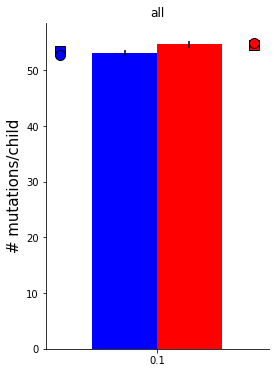

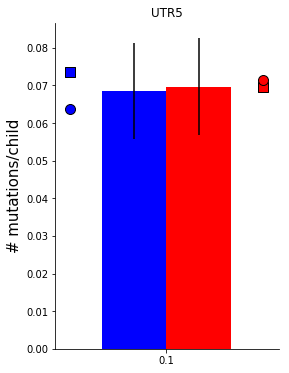

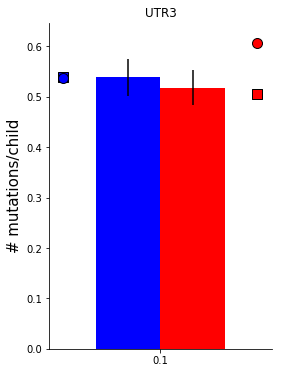

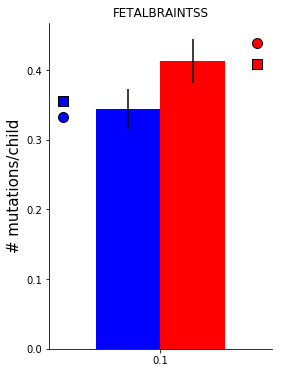

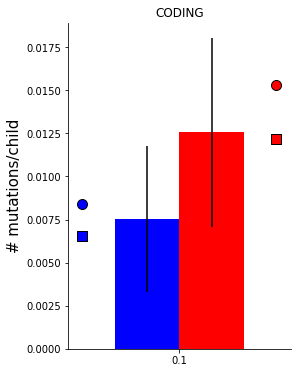

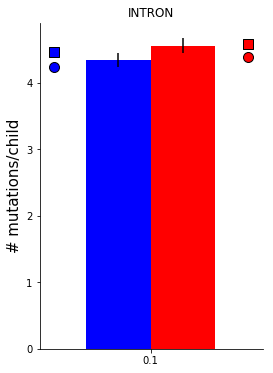

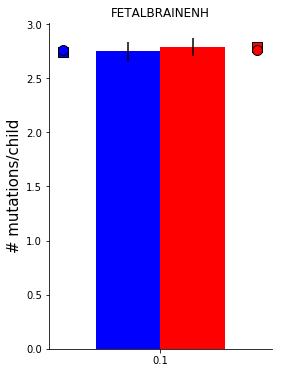

In [119]:
# Mutation count by category
fdata_list_annotations = [finaldata]
fdata_list_annotations_nohom = [finaldata[finaldata["period_x"]>1]]
fdata_labels_list_annotations = ["all"]
for col in ['FEATURE-UTR5','FEATURE-UTR3', 'FEATURE-FETALBRAINTSS', 'FEATURE-CODING', 'FEATURE-INTRON', 'FEATURE-FETALBRAINENH']:
    fdata_list_annotations.append(finaldata[(finaldata[col]>0)])
    fdata_list_annotations_nohom.append(finaldata[(finaldata[col]>0) & (finaldata["period_x"]>1)])
    fdata_labels_list_annotations.append(col.split("-")[1])
PlotMutationCounts(finaldata, fdata_list_annotations, fdata_labels_list_annotations, figprefix="Figure3")

# Fig. 3B Relative risk by category

#### all #####
Num total/male/female=171578.0/117031.0/54547.0
#### UTR5 #####
Num total/male/female=220.0/153.0/67.0
#### UTR3 #####
Num total/male/female=1683.0/1117.0/566.0
#### FETALBRAINTSS #####
Num total/male/female=1206.0/843.0/363.0
#### CODING #####
Num total/male/female=32.0/22.0/10.0
#### INTRON #####
Num total/male/female=14164.0/9788.0/4376.0
#### FETALBRAINENH #####
Num total/male/female=8819.0/5985.0/2834.0
##### all #####
RR - all: 1.03 (1.02-1.04)
RR - male: 1.02 (1.01-1.03)
RR - female: 1.04 (1.02-1.06)
##### UTR5 #####
RR - all: 1.02 (0.78-1.33)
RR - male: 0.94 (0.69-1.34)
RR - female: 1.12 (0.53-1.87)
##### UTR3 #####
RR - all: 0.96 (0.87-1.06)
RR - male: 0.94 (0.83-1.06)
RR - female: 1.13 (0.91-1.37)
##### FETALBRAINTSS #####
RR - all: 1.20 (1.07-1.35)
RR - male: 1.15 (1.00-1.34)
RR - female: 1.32 (1.02-1.65)
##### CODING #####
RR - all: 1.67 (0.84-3.82)
RR - male: 1.85 (0.81-9.91)
RR - female: 1.82 (0.07-5.95)
##### INTRON #####
RR - all: 1.05 (1.02-1.08)
RR - ma

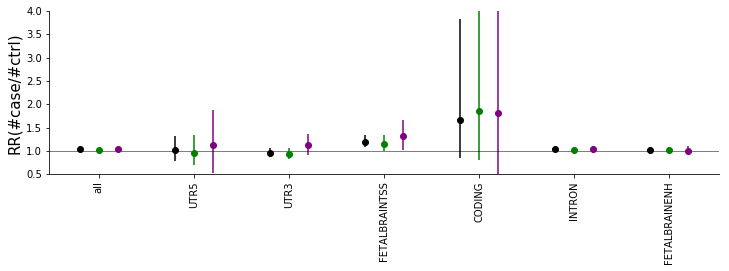

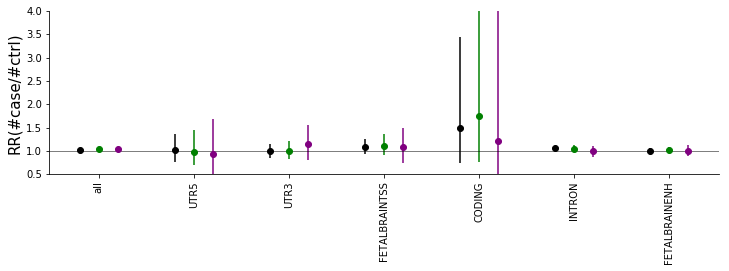

In [183]:
import random

# binomial method
def GetRRLowHigh(aff_counts, unaff_counts):
    # return [low, high] for 95% CI
    num_unaff = len(unaff_counts)
    num_aff = len(aff_counts)
    total = np.sum(unaff_counts)+np.sum(aff_counts)
    perc = np.sum(aff_counts)/total
    perc_se = np.sqrt(perc*(1-perc)/total)
    perc_low = perc-1.96*perc_se
    perc_high = perc+1.96*perc_se
    if perc_low < 0: perc_low = 0
    if perc_high > 1: perc_high = 1
    try:
        rr_low = num_unaff*1.0/num_aff*perc_low/(1-perc_low)
        rr_high = num_unaff*1.0/num_aff*perc_high/(1-perc_high)
        return rr_low, rr_high
    except: return np.nan, np.nan

def PlotRR(full_fdata, fdata_list, fdata_list_labels, plot=True, maxORy=None, plotsex=False, figsize=None, figprefix="Figure3",
          colors=None):
    fdata = full_fdata
    
    # Get list of families to use
    families = set(fdata["family"])
    aff_female_families = set(fdata[(fdata["phenotype"]==2) & (fdata["sex"]=="female")]["family"])
    unaff_female_families = set(fdata[(fdata["phenotype"]==1) & (fdata["sex"]=="female")]["family"])
    aff_male_families = set(fdata[(fdata["phenotype"]==2) & (fdata["sex"]=="male")]["family"])
    unaff_male_families = set(fdata[(fdata["phenotype"]==1) & (fdata["sex"]=="male")]["family"])

    # Keep track of the percentage of mutations that are cases/ctrls for each category
    RR_all = []
    RR_female = []
    RR_male = []
    
    RR_low_all = []
    RR_low_female = []
    RR_low_male = []
    RR_high_all = []
    RR_high_female = []
    RR_high_male = []
    
    for i in range(len(fdata_list)):
        usedata = fdata_list[i]
        flabel = fdata_list_labels[i]
        
        # Get counts of unaff/aff mutations
        child_counts = usedata.groupby(["child","phenotype","family","father_age_birth_years"], as_index=False).agg({"posterior": len})
        child_counts.columns = ["child","phenotype","family","father_age_birth_years","nummut"]
        child_counts_by_sex = usedata.groupby(["child","phenotype","family","sex"], as_index=False).agg({"posterior": len})
        child_counts_by_sex.columns = ["child","phenotype","family","sex","nummut"]
        aff_counts = GetCounts(child_counts, 2, families)
        unaff_counts = GetCounts(child_counts, 1, families)
        aff_male_counts = GetCounts(child_counts_by_sex, 2, aff_male_families, sex="male")
        aff_female_counts = GetCounts(child_counts_by_sex, 2, aff_female_families, sex="female")
        unaff_male_counts = GetCounts(child_counts_by_sex, 1, unaff_male_families, sex="male")
        unaff_female_counts = GetCounts(child_counts_by_sex, 1, unaff_female_families, sex="female")

        # Get RR for all/male/female
        RR_all.append(np.mean(aff_counts)/np.mean(unaff_counts))
        RR_female.append(np.mean(aff_female_counts)/np.mean(unaff_female_counts))
        RR_male.append(np.mean(aff_male_counts)/np.mean(unaff_male_counts))

        low_all, high_all = GetRRLowHigh(aff_counts, unaff_counts)
        RR_low_all.append(low_all)
        RR_high_all.append(high_all)
        low_male, high_male = GetRRLowHigh(aff_male_counts, unaff_male_counts)
        RR_low_male.append(low_male)
        RR_high_male.append(high_male)
        low_female, high_female = GetRRLowHigh(aff_female_counts, unaff_female_counts)
        RR_low_female.append(low_female)
        RR_high_female.append(high_female)        
        print("#### %s #####"%fdata_list_labels[i])
        print("Num total/male/female=%s/%s/%s"%(np.sum(aff_counts)+np.sum(unaff_counts),
                                                 np.sum(aff_male_counts)+np.sum(unaff_male_counts),
                                               np.sum(aff_female_counts)+np.sum(unaff_female_counts)))

    ########### Print results #########
    for i in range(len(fdata_list)):
        print("##### %s #####"%(fdata_list_labels[i]))
        print("RR - all: %.2f (%.2f-%.2f)"%(RR_all[i], RR_low_all[i], RR_high_all[i]))
        print("RR - male: %.2f (%.2f-%.2f)"%(RR_male[i], RR_low_male[i], RR_high_male[i]))
        print("RR - female: %.2f (%.2f-%.2f)"%(RR_female[i], RR_low_female[i], RR_high_female[i]))
        
    ########### Plot #########
    if not plot: return
    xvals = range(len(fdata_list))
    fig = plt.figure()
    if figsize is None:
        fig.set_size_inches((5+len(fdata_list), 3))
    else:
        fig.set_size_inches(figsize)
    ax = fig.add_subplot(111)
    W2 = 0.2
    RE_err_low = np.array(RR_all)-np.array(RR_low_all)
    RE_err_high = np.array(RR_high_all)-np.array(RR_all)
    ax.errorbar(xvals, RR_all, yerr = [RE_err_low, RE_err_high], color="black", fmt="o")
    if plotsex:
        RE_err_low_male = np.array(RR_male)-np.array(RR_low_male)
        RE_err_high_male = np.array(RR_high_male)-np.array(RR_male)
        RE_err_low_female = np.array(RR_female)-np.array(RR_low_female)
        RE_err_high_female = np.array(RR_high_female)-np.array(RR_female)
        ax.errorbar([item+W2 for item in xvals], RR_male, yerr = [RE_err_low_male, RE_err_high_male], color="green", fmt="o")
        ax.errorbar([item+W2*2 for item in xvals], RR_female, yerr = [RE_err_low_female, RE_err_high_female], color="purple", fmt="o")
    if maxORy is not None:
        ax.set_ylim(bottom=0.5, top=maxORy)
    ax.axhline(y=1, linestyle="solid", linewidth=0.5, color="black")
    if plotsex:
        ax.set_xticks([item+W2 for item in xvals])
    else:
        ax.set_xticks(xvals)
    ax.set_xticklabels(fdata_list_labels, rotation=90)
    ax.set_ylabel("RR(#case/#ctrl)", size=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    if figprefix is not None:
        fig.savefig(os.path.join(OUTDIR, figprefix+"-RR.pdf"))

PlotRR(finaldata, fdata_list_annotations, fdata_labels_list_annotations, maxORy=4, plotsex=True, figprefix="Figure3")
PlotRR(finaldata, fdata_list_annotations_nohom, fdata_labels_list_annotations, maxORy=4, plotsex=True, figprefix="Figure3-NoHomopolymers")


In [189]:
# Compare if burden different between subdata vs. full data 
def CompareBurden(fulldata, subdata):
    num_total_aff = fulldata[fulldata["phenotype"]==2].shape[0]
    num_total_unaff = fulldata[fulldata["phenotype"]==1].shape[0]
    num_sub_aff = subdata[subdata["phenotype"]==2].shape[0]
    num_sub_unaff = subdata[subdata["phenotype"]==1].shape[0]
    # 2x2 table of mutation in annot/not and in proband/not
    table = [[num_sub_aff, num_total_aff-num_sub_aff],
            [num_sub_unaff, num_total_unaff-num_sub_unaff]]
    return scipy.stats.fisher_exact(table, alternative="greater")

print(CompareBurden(finaldata, finaldata[finaldata["FEATURE-FETALBRAINTSS"]>0]))
print(CompareBurden(finaldata[finaldata["sex"]=="male"], finaldata[(finaldata["sex"]=="male") & (finaldata["FEATURE-FETALBRAINTSS"]>0)]))
print(CompareBurden(finaldata[finaldata["sex"]=="female"], finaldata[(finaldata["sex"]=="female") & (finaldata["FEATURE-FETALBRAINTSS"]>0)]))

(1.1668501797467958, 0.004213459599071751)
(1.127407300216793, 0.05580205373945781)
(1.2661444923010297, 0.03483464126435917)


# Fig.  3C Mutation size

###### all ######
MannwhitneyuResult(statistic=3659432165.0, pvalue=0.017489510058466225)
Unaff n=84515 mean=2.434206945512631
Aff n=87063 mean=2.465031069455452
###### UTR5 ######
MannwhitneyuResult(statistic=6213.5, pvalue=0.6531485293637433)
Unaff n=109 mean=1.798165137614679
Aff n=111 mean=1.8288288288288288
###### UTR3 ######
MannwhitneyuResult(statistic=357073.0, pvalue=0.6365612235360728)
Unaff n=858 mean=2.2762237762237763
Aff n=825 mean=2.4375757575757575
###### FETALBRAINTSS ######
MannwhitneyuResult(statistic=167012.5, pvalue=0.008134303155412448)
Unaff n=548 mean=2.0364963503649633
Aff n=658 mean=2.3677811550151975
###### CODING ######
MannwhitneyuResult(statistic=120.5, pvalue=0.5174439440836233)
Unaff n=12 mean=2.0
Aff n=20 mean=1.65
###### INTRON ######
MannwhitneyuResult(statistic=25059800.5, pvalue=0.49437898607216696)
Unaff n=6912 mean=2.4500868055555554
Aff n=7252 mean=2.433949255377827
###### FETALBRAINENH ######
MannwhitneyuResult(statistic=9527030.0, pvalue=0.0361

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


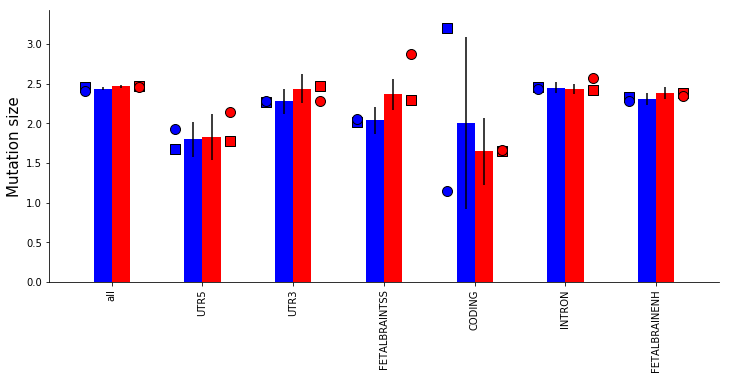

In [64]:
# Mutation size by category
PlotMutationSize(fdata_list_annotations, fdata_labels_list_annotations, figprefix="Figure3")

# Figure 4A: Relative risk by AF

#### All #####
Num total/male/female=171578.0/117031.0/54547.0
#### 0.05-1.1 #####
Num total/male/female=94021.0/64205.0/29816.0
#### 0.01-0.05 #####
Num total/male/female=31672.0/21522.0/10150.0
#### 0.001-0.01 #####
Num total/male/female=17095.0/11525.0/5570.0
#### Count1-0.001 #####
Num total/male/female=4302.0/2903.0/1399.0
#### -1-0 #####
Num total/male/female=2559.0/1762.0/797.0
##### All #####
RR - all: 1.03 (1.02-1.04)
RR - male: 1.02 (1.01-1.03)
RR - female: 1.04 (1.02-1.06)
##### 0.05-1.1 #####
RR - all: 1.04 (1.02-1.05)
RR - male: 1.03 (1.02-1.05)
RR - female: 1.04 (1.01-1.07)
##### 0.01-0.05 #####
RR - all: 1.02 (1.00-1.04)
RR - male: 1.01 (0.98-1.04)
RR - female: 1.04 (0.99-1.09)
##### 0.001-0.01 #####
RR - all: 1.01 (0.98-1.04)
RR - male: 1.02 (0.98-1.06)
RR - female: 1.01 (0.94-1.08)
##### Count1-0.001 #####
RR - all: 1.03 (0.97-1.09)
RR - male: 1.02 (0.95-1.10)
RR - female: 1.10 (0.96-1.25)
##### -1-0 #####
RR - all: 1.10 (1.01-1.18)
RR - male: 1.05 (0.96-1.16)
RR - fem

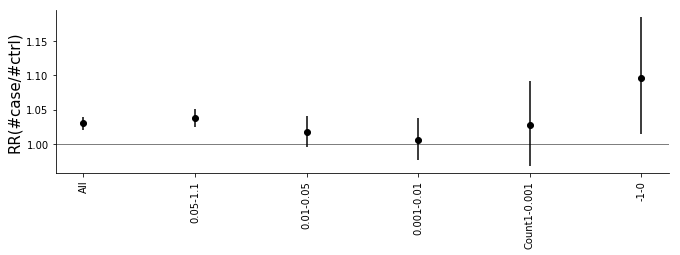

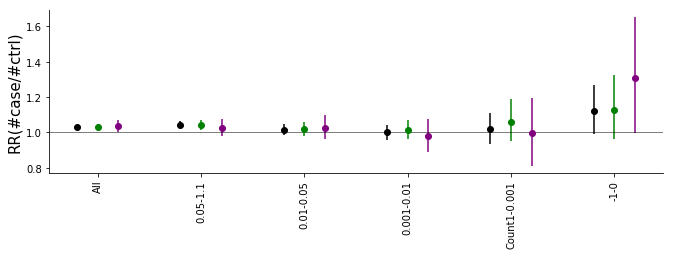

In [185]:
mintotal = 0.8*max(fdata["total"])

# All
fdata_list = [finaldata]
fdata_list_nohom = [finaldata[finaldata["period_x"]>1]]
fdata_labels_list = ["All"]

# Other freq bins
for freqpair in [(0.05, 1.1), (0.01, 0.05), (0.001, 0.01), (-1,0.001), (-1, 0)]:
    minfreq, maxfreq = freqpair
    if minfreq == -1 and maxfreq > 0:
        fdata_list.append(finaldata[(finaldata["total"]>=mintotal) & (finaldata["freq"]>0) & (finaldata["freq"]<=maxfreq)])
        fdata_list_nohom.append(finaldata[(finaldata["period_x"]>1) & (finaldata["total"]>=mintotal) & (finaldata["freq"]>0) & (finaldata["freq"]<=maxfreq)])
        fdata_labels_list.append("Count1-%s"%(maxfreq))
    else:
        fdata_list.append(finaldata[(finaldata["total"]>=mintotal) & (finaldata["freq"]>minfreq) & (finaldata["freq"]<=maxfreq)])
        fdata_list_nohom.append(finaldata[(finaldata["period_x"]>1) &(finaldata["total"]>=mintotal) & (finaldata["freq"]>minfreq) & (finaldata["freq"]<=maxfreq)])
        fdata_labels_list.append("%s-%s"%(minfreq,maxfreq))
        
PlotRR(finaldata, fdata_list, fdata_labels_list, plotsex=False, figprefix="Figure4-AF")
PlotMutationCounts(finaldata, fdata_list, fdata_labels_list, plot=False, figprefix=None)

PlotRR(finaldata, fdata_list_nohom, fdata_labels_list, plotsex=True, figprefix="Figure4-AF-nohom")
PlotMutationCounts(finaldata, fdata_list_nohom, fdata_labels_list, plot=False, figprefix=None)


In [194]:
print(CompareBurden(finaldata, finaldata[(finaldata["freq"]==0) & (finaldata["total"]>=mintotal)]))
print(CompareBurden(finaldata[finaldata["sex"]=="male"], finaldata[(finaldata["sex"]=="male") & (finaldata["freq"]==0) & (finaldata["total"]>=mintotal)]))
print(CompareBurden(finaldata[finaldata["sex"]=="female"], finaldata[(finaldata["sex"]=="female") & (finaldata["freq"]==0) & (finaldata["total"]>=mintotal)]))

(1.0647476108893432, 0.060107281633793384)
(1.0314431057845774, 0.27939204005056756)
(1.1650084311889959, 0.04288545921816155)


# Figure 4b: RR by AF bin/locus selection

#### All #####
Num total/male/female=171578.0/117031.0/54547.0
#### All-selp #####
Num total/male/female=901.0/597.0/304.0
#### 0.05-1.1 #####
Num total/male/female=94021.0/64205.0/29816.0
#### 0.05-1.1-selp #####
Num total/male/female=293.0/198.0/95.0
#### 0.01-0.05 #####
Num total/male/female=31672.0/21522.0/10150.0
#### 0.01-0.05-selp #####
Num total/male/female=344.0/227.0/117.0
#### 0.001-0.01 #####
Num total/male/female=17095.0/11525.0/5570.0
#### 0.001-0.01-selp #####
Num total/male/female=184.0/121.0/63.0
#### Count1-0.001 #####
Num total/male/female=4302.0/2903.0/1399.0
#### Count1-0.001-selp #####
Num total/male/female=51.0/29.0/22.0
#### -1-0 #####
Num total/male/female=2559.0/1762.0/797.0
#### -1-0-selp #####
Num total/male/female=19.0/15.0/4.0
##### All #####
RR - all: 1.03 (1.02-1.04)
RR - male: 1.02 (1.01-1.03)
RR - female: 1.04 (1.02-1.06)
##### All-selp #####
RR - all: 1.10 (0.96-1.25)
RR - male: 1.15 (0.97-1.37)
RR - female: 1.18 (0.87-1.52)
##### 0.05-1.1 #####
RR - 

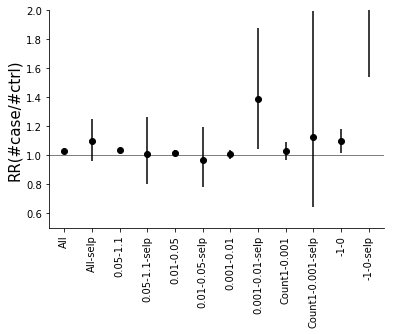

In [165]:
mintotal = 0.8*max(fdata["total"])

# Load selection estimates and generate per-allele scores
def GetSelectionScore(x):
    if np.isnan(x["ABC_s_median"]): return np.nan
    diff = abs(x["newallele"]-x["optimal_ru"])
    s_est = x["ABC_s_median"]
    return diff*s_est

seldata = pd.read_csv("/storage/BonnieH/selection_project/per_locus/results/per_locus_results_prelim_all_per.txt", sep="\t")
seldata["pos"] = seldata["start"]
seldata = seldata[~np.isnan(seldata["LRT_p_value"])]
seldata["ABC_upper"] = seldata["ABC_s_95%_CI"].apply(lambda x: float(x.split(",")[1].split(")")[0]))
seldata["ABC_lower"] = seldata["ABC_s_95%_CI"].apply(lambda x: float(x.split(",")[0].split("(")[1]))
seldata = pd.merge(finaldata, seldata, on=["chrom","pos"], how="left")
seldata["pscore"] = seldata.apply(GetSelectionScore, 1)


# All
fdata_list = [seldata, seldata[(seldata["LRT_p_value"]<0.05) & ~np.isnan(seldata["LRT_p_value"])] ]
fdata_labels_list = ["All", "All-selp"]
colors = ["black","blue"]

# Other freq bins
for freqpair in [(0.05, 1.1), (0.01, 0.05), (0.001, 0.01), (-1,0.001), (-1, 0)]:
    minfreq, maxfreq = freqpair
    if minfreq == -1 and maxfreq > 0:
        fdata_list.append(seldata[(seldata["total"]>=mintotal) & (seldata["freq"]>0) & (seldata["freq"]<=maxfreq)])
        fdata_labels_list.append("Count1-%s"%(maxfreq))
        colors.append("black")
        
        fdata_list.append(seldata[(seldata["LRT_p_value"]<0.05) & ~np.isnan(seldata["LRT_p_value"]) &
                                  (seldata["total"]>=mintotal) & (seldata["freq"]>0) & (seldata["freq"]<=maxfreq)])
        fdata_labels_list.append("Count1-%s-selp"%(maxfreq))
        colors.append("blue")

    else:
        fdata_list.append(seldata[(seldata["total"]>=mintotal) & (seldata["freq"]>minfreq) & (seldata["freq"]<=maxfreq)])
        fdata_labels_list.append("%s-%s"%(minfreq,maxfreq))
        colors.append("black")
        
        fdata_list.append(seldata[(seldata["LRT_p_value"]<0.05) & ~np.isnan(seldata["LRT_p_value"]) &
                (seldata["total"]>=mintotal) & (seldata["freq"]>minfreq) & (seldata["freq"]<=maxfreq)])
        fdata_labels_list.append("%s-%s-selp"%(minfreq,maxfreq))
        colors.append("blue")

        
PlotRR(finaldata, fdata_list, fdata_labels_list, plotsex=False, maxORy=2, figprefix="Figure4-LocusSel", figsize=(6, 4))



(-0.5, 1.1)
[0, 0.0001, 0.001, 0.005]
#### 0 #####
Num total/male/female=55584.0/37709.0/17875.0
#### 0.0001 #####
Num total/male/female=38188.0/25862.0/12326.0
#### 0.001 #####
Num total/male/female=3143.0/2120.0/1023.0
#### 0.005 #####
Num total/male/female=857.0/577.0/280.0
##### 0 #####
RR - all: 1.02 (1.01-1.04)
RR - male: 1.03 (1.01-1.05)
RR - female: 1.02 (0.99-1.06)
##### 0.0001 #####
RR - all: 1.02 (1.00-1.04)
RR - male: 1.02 (1.00-1.05)
RR - female: 1.02 (0.97-1.06)
##### 0.001 #####
RR - all: 1.09 (1.01-1.17)
RR - male: 1.14 (1.04-1.25)
RR - female: 1.06 (0.90-1.22)
##### 0.005 #####
RR - all: 1.13 (0.99-1.30)
RR - male: 1.19 (1.01-1.43)
RR - female: 1.13 (0.83-1.48)


(0, 0.01)
[0, 0.0001, 0.001, 0.005]
#### 0 #####
Num total/male/female=7675.0/5181.0/2494.0
#### 0.0001 #####
Num total/male/female=6348.0/4303.0/2045.0
#### 0.001 #####
Num total/male/female=979.0/640.0/339.0
#### 0.005 #####
Num total/male/female=313.0/202.0/111.0
##### 0 #####
RR - all: 1.01 (0.97-1.06)
R

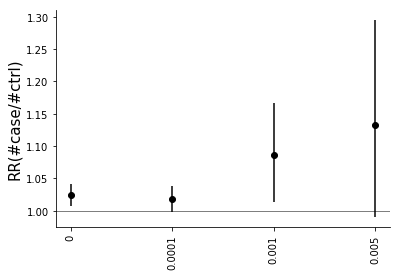

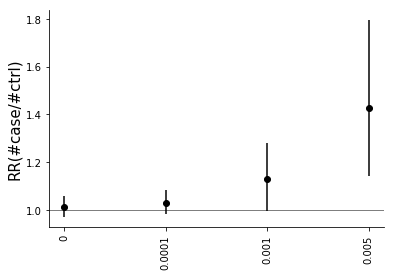

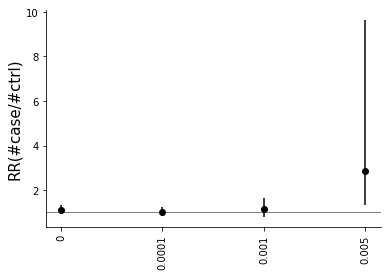

In [195]:
# Per allele score, by af

for freqbin in [(-0.5,1.1), (0, 0.01), (-1, 0)]:
    print("\n\n%s"%str(freqbin))
    fdata_list = []
    fdata_list_labels = []
    minfreq, maxfreq = freqbin
    for sthresh in [0, 10e-5, 10e-4, 5e-3]:
        fdata_list.append(seldata[(seldata["freq"]>minfreq) & (seldata["freq"]<=maxfreq) &
                                  ~np.isnan(seldata["LRT_p_value"]) & 
                                  (seldata["pscore"]>=sthresh) & (seldata["total"]>=mintotal)])
        fdata_list_labels.append(sthresh)
    print(fdata_list_labels)
    PlotRR(finaldata, fdata_list, fdata_list_labels, plotsex=False,
           figprefix="Figure4-AlleleSel-%s"%str(freqbin), figsize=(6, 4))

# Supplementary Table 7 - TRs under selection

In [169]:
cols = ["phenotype","chrom","pos","mutsize","motif","freq","pscore","TSS_GENE","LRT_p_value"]
seldata[(seldata["pscore"]>0.005) & (seldata["freq"]<=0)].sort_values(["phenotype","pscore"])[cols]

,phenotype,chrom,pos,mutsize,motif,freq,pscore,TSS_GENE,LRT_p_value
123843,1,19,7724473,-3,AC,0.0,0.00528,CLEC4G,0.049935
13043,1,4,30716894,1,AGC,0.0,0.00672,PCDH7,0.784834
11925,1,5,5725645,-4,AC,0.0,0.00788,AC026736.1,0.029963
165624,1,3,47997708,-3,AAAG,0.0,0.00861,MAP4,0.038560
5330,1,3,139114125,-4,AC,0.0,0.01180,MRPS22,0.079717
329,1,11,48001350,5,AC,0.0,0.01350,PTPRJ-AS1,0.099331
69682,1,17,2057111,3,CCG,0.0,0.03378,HIC1,0.108880
8494,2,7,68421891,4,AAAT,0.0,0.00504,AC093655.1,1.000000
54733,2,5,24946660,-3,AC,0.0,0.00540,RF00019,0.085941
136424,2,17,55529610,-6,AC,0.0,0.00690,SMIM36,0.080632


# Supplementary Table 6: Coding mutations

In [170]:
finaldata[finaldata["FEATURE-CODING"]>0] # autosome only. add chrX separately. should be 32 autosomal coding

,chrom,pos,period_x,prior,family,child,phenotype,posterior,newallele,mutsize,...,gene-utr3,gene-upstream5kb,TSS_GENE,count,freq,het,total,sex,father_age_birth_years,absmutsize
22651,1,50419102,3,0.001,11156,SSC02681,2,0.765081,7,-2,...,0,0,DMRTA2,1115.0,0.174546,0.299199,6388,male,35.333333,2
59214,2,20667363,3,0.001,11471,SSC02328,2,1.000000,20,2,...,0,0,GDF7,0.0,0.000000,0.461576,6128,male,34.166667,2
66352,12,118068523,3,0.001,11552,SSC02432,1,1.000000,7,1,...,0,0,AC131238.1,166.0,0.025515,0.377465,6506,female,38.333333,1
67048,3,40462030,3,0.001,11563,SSC02139,2,0.996029,17,1,...,0,0,RPL14,88.0,0.013559,0.797404,6490,male,40.000000,1
69682,17,2057111,3,0.001,11599,SSC02761,1,1.000000,11,3,...,0,0,HIC1,0.0,0.000000,0.001230,6502,male,28.833333,3
70293,1,154869724,3,0.001,11615,SSC02899,1,0.998672,17,-1,...,0,0,KCNN3,684.0,0.111510,0.799814,6134,female,30.166667,1
70294,1,154869724,3,0.001,11989,SSC03867,2,1.000000,23,2,...,0,0,KCNN3,14.0,0.002282,0.799814,6134,male,34.000000,2
70295,1,154869724,3,0.001,13620,SSC07966,1,1.000000,20,1,...,0,0,KCNN3,724.0,0.118031,0.799814,6134,female,41.166667,1
83267,12,102958394,3,0.001,11888,SSC03711,2,1.000000,14,1,...,0,0,PAH,95.0,0.014670,0.498507,6476,male,36.833333,1
88795,3,49312475,1,0.001,12010,SSC03574,2,0.738941,14,1,...,0,0,USP4,6.0,0.000932,0.002482,6440,female,32.500000,1


# Supplementary Table 8 - expansions

In [171]:
ndata # add chrX separately.

,chrom,pos,period,prior,family,child,phenotype,posterior,newallele,mutsize,...,child_gt,mat_gt,pat_gt,encl_child,encl_mother,encl_father,encl_parent,long_mother,long_father,phase
0,2,34119626,2,1.000000e-08,11462,SSC02332,2,-1,38,5,...,"19,38","19,29","23,33",5,0,0,0,0,0,phase2
1,4,78629320,2,1.000000e-08,11447,SSC00452,2,-1,43,5,...,"43,50","22,38","19,28",0,0,0,0,0,0,phase2
2,10,107285591,5,1.000000e-08,14350,SSC10652,1,-1,19,6,...,"13,19","12,13","12,13",6,0,0,0,0,0,phase2
3,7,1023625,2,1.000000e-08,13890,SSC09557,1,-1,39,9,...,"22,39","21,30","22,27",0,0,0,0,0,0,phase3_1
4,7,92688582,2,1.000000e-08,14329,SSC11980,2,-1,33,6,...,"27,33","25,27","26,27",0,0,0,0,0,0,phase1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,17,39183338,3,1.000000e-08,12780,SSC05611,1,-1,25,7,...,"8,25","9,18","8,9",0,0,0,0,0,0,phase2
71,11,36270138,2,1.000000e-08,13916,SSC09590,2,-1,27,7,...,"14,27","14,19","15,20",0,0,0,0,0,0,phase3_1
72,5,59131598,2,1.000000e-08,14360,SSC11642,2,-1,27,6,...,"16,27","16,21","16,16",8,0,0,0,0,0,phase1
73,16,20691752,2,1.000000e-08,13513,SSC07968,2,-1,31,6,...,"24,31","22,24","18,25",8,0,0,0,0,0,phase3_1
